## Install Gurobi

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 74.1 MB/s eta 0:00:00


### Import packages

In [2]:
import numpy as np
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt

## Mount drive to be able to access data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# #!ls /content/drive/My\ Drive/

Mounted at /content/drive


## First stage model

### Load in data

In [3]:
# Load CSV data
file_path = 'ev_charging_congestion.csv'
data = pd.read_csv(file_path)

data.head()

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total_chargers,Total_EV,Total_Capacity_Level_1,Total_Capacity_Level_2,Total_Capacity_DC_Fast,Total_Charger_Capacity,Sessions_Level_1,Sessions_Level_2,Sessions_DC_Fast,Total_Effective_Sessions,Congestion_Ratio
0,Alameda,4,72,1590,3667,510,50,5893,57097,9120,3154200,4032000,7195320,31.92,12616.8,18816.0,31464.72,1.814636
1,Alpine,0,0,12,0,0,0,12,12,0,7200,0,7200,0.00,28.8,0.0,28.80,0.416667
2,Amador,0,0,26,0,8,0,34,269,0,15600,57600,73200,0.00,62.4,268.8,331.20,0.812198
3,Butte,6,0,72,53,25,1,157,1310,720,75000,187200,262920,2.52,300.0,873.6,1176.12,1.113832
4,Calaveras,0,2,9,0,12,0,23,334,240,5400,86400,92040,0.84,21.6,403.2,425.64,0.784701


In [4]:
population_density = pd.read_csv('table-data.csv')
population_density = population_density[['county', 'densityMi']]
population_density['county'] = population_density['county'].str[:-7]
population_density.head()

,county,densityMi
0,Los Angeles,2366.237685
1,San Diego,775.004751
2,Orange,3935.861286
3,Riverside,348.265085
4,San Bernardino,109.443592


In [ ]:
data = pd.merge(data, population_density, left_on='County', right_on='county', how='left')
data.head()

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total_chargers,county_x,Total_EV,...,Congestion,Total_Charge_Capacity,EV_to_Charger_Ratio,Total_Capacity_Level_1,Total_Capacity_Level_2,Total_Capacity_DC_Fast,Total_Capacity,Congestion_Ratio,county_y,densityMi
0,Alameda,4,72,1590,3667,510,50,5893,Alameda,57097,...,0.000834,192770,9.688953,9120,3154200,4032000,7195320,0.007935,Alameda,2192.831750
1,Alpine,0,0,12,0,0,0,12,Alpine,12,...,0.833333,300,1.000000,0,7200,0,7200,0.001667,Alpine,1.479675
2,Amador,0,0,26,0,8,0,34,Amador,269,...,0.081967,3050,7.911765,0,15600,57600,73200,0.003675,Amador,70.805042
3,Butte,6,0,72,53,25,1,157,Butte,1310,...,0.022821,9330,8.343949,720,75000,187200,262920,0.004983,Butte,126.512836
4,Calaveras,0,2,9,0,12,0,23,Calaveras,334,...,0.065189,3825,14.521739,240,5400,86400,92040,0.003629,Calaveras,45.660784


In [ ]:
data.drop(columns=['county_y', 'county_x'], inplace=True)
data.columns

Index(['County', 'Public Level 1', 'Shared Private Level 1', 'Public Level 2',
       'Shared Private Level 2', 'Public DC Fast', 'Shared Private DC Fast',
       'Total_chargers', 'Total_EV', 'Total_Level_1_Power',
       'Total_Level_2_Power', 'Total_DC_Fast_Power', 'Total_Charging_Power',
       'Total_Charging_Time', 'Congestion', 'Total_Charge_Capacity',
       'EV_to_Charger_Ratio', 'Total_Capacity_Level_1',
       'Total_Capacity_Level_2', 'Total_Capacity_DC_Fast', 'Total_Capacity',
       'Congestion_Ratio', 'densityMi'],
      dtype='object')

### Extract data, create first stage model

In [ ]:
from gurobipy import Model, GRB, quicksum

# Extract data from the DataFrame
counties = data['County'].tolist()
total_evs = dict(zip(data['County'], data['Total_EV']))
total_capacity = dict(zip(data['County'], data['Total_Capacity']))
congestion_ratio = dict(zip(data['County'], data['Congestion_Ratio']))

# Cost and budget data
charger_cost = 5000  # Cost per charger
budget = 32000000  # Budget available
congestion_weight = 1000  # Emphasis on reducing congestion

# Calculate minimum chargers based on EVs: 1 charger per 50 EVs
min_chargers = {county: max(0, total_evs[county] // 1000) for county in counties}

# First Stage: Infrastructure Planning
first_stage_model = Model("FirstStage")

# Decision variables: Number of chargers per county
chargers = first_stage_model.addVars(counties, vtype=GRB.INTEGER, name="Chargers")

# Objective: Minimize the weighted sum of congestion and cost
# Adjusted to place more emphasis on congestion
first_stage_model.setObjective(
    quicksum(congestion_weight * congestion_ratio[county] * chargers[county] for county in counties) +
    quicksum(charger_cost * chargers[county] for county in counties),
    GRB.MINIMIZE
)

# Constraints
for county in counties:
    # Congestion ratio constraint
    first_stage_model.addConstr(
        congestion_ratio[county] * chargers[county] <= total_capacity[county] * 1,
        f"CongestionRatio_{county}"
    )
    # Demand satisfaction constraint: Ensure chargers meet EVs in the county
    first_stage_model.addConstr(
        chargers[county] * total_capacity[county] >= total_evs[county] * 1.1,  # Increased demand requirement
        f"Demand_{county}"
    )
    # Minimum chargers constraint based on EVs
    first_stage_model.addConstr(
        chargers[county] >= min_chargers[county],
        f"MinChargers_{county}"
    )

    # Encourage more chargers in high-congestion counties
    first_stage_model.addConstr(
    chargers[county] >= congestion_ratio[county] * 10,
    f"PrioritizeHighCongestion_{county}"
)

# Budget constraint
first_stage_model.addConstr(
    quicksum(charger_cost * chargers[county] for county in counties) <= budget,
    "BudgetConstraint"
)

# Solve the model
first_stage_model.optimize()

# Extract and print results
if first_stage_model.Status == GRB.OPTIMAL:
    optimal_chargers = {county: chargers[county].X for county in counties}
    print("First Stage Results (Optimal Chargers):", optimal_chargers)
else:
    print("First Stage Optimization Failed")


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 233 rows, 58 columns and 290 nonzeros
Model fingerprint: 0xa6b1a350
Variable types: 0 continuous, 58 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-05, 3e+07]
  Objective range  [5e+03, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 3e+07]
Found heuristic solution: objective 4135614.4254
Presolve removed 233 rows and 58 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 4.13561e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.135614425408e+06, best boun

In [ ]:
# View output
optimal_chargers

{'Alameda': 57.0,
 'Alpine': 1.0,
 'Amador': 1.0,
 'Butte': 1.0,
 'Calaveras': 1.0,
 'Colusa': 1.0,
 'Contra Costa': 33.0,
 'Del Norte': 1.0,
 'El Dorado': 3.0,
 'Fresno': 7.0,
 'Glenn': 1.0,
 'Humboldt': 1.0,
 'Imperial': 1.0,
 'Inyo': 1.0,
 'Kern': 4.0,
 'Kings': 1.0,
 'Lake': 1.0,
 'Lassen': 1.0,
 'Los Angeles': 207.0,
 'Madera': 1.0,
 'Marin': 12.0,
 'Mariposa': 1.0,
 'Mendocino': 1.0,
 'Merced': 1.0,
 'Modoc': 1.0,
 'Mono': 1.0,
 'Monterey': 4.0,
 'Napa': 3.0,
 'Nevada': 1.0,
 'Orange': 101.0,
 'Placer': 8.0,
 'Plumas': 1.0,
 'Riverside': 33.0,
 'Sacramento': 23.0,
 'San Benito': 1.0,
 'San Bernardino': 24.0,
 'San Diego': 69.0,
 'San Francisco': 21.0,
 'San Joaquin': 8.0,
 'San Luis Obispo': 5.0,
 'San Mateo': 34.0,
 'Santa Barbara': 6.0,
 'Santa Clara': 84.0,
 'Santa Cruz': 7.0,
 'Shasta': 1.0,
 'Sierra': 1.0,
 'Siskiyou': 1.0,
 'Solano': 7.0,
 'Sonoma': 11.0,
 'Stanislaus': 3.0,
 'Sutter': 1.0,
 'Tehama': 1.0,
 'Trinity': 1.0,
 'Tulare': 2.0,
 'Tuolumne': 1.0,
 'Ventura': 17.0,

## Second stage model

### With scenarios

#### per charger

In [ ]:
# First stage model (assumed already defined and solved)
if first_stage_model.Status == GRB.OPTIMAL:
    # Extract results into a dictionary
    optimal_chargers = {county: int(chargers[county].X) for county in counties}
    print("First Stage Optimal Chargers:", optimal_chargers)
else:
    print("First Stage Optimization Failed")
    optimal_chargers = None

# Baseline demand for each county (using total_ev numbers)
baseline_demand = dict(zip(data['County'], data['Total_EV']))
total_capacity = dict(zip(data['County'], data['Total_Capacity']))

# Define charger capacity
charger_capacity = 50  # Example capacity per charger in kWh

# Step 1: Simulate demand scenarios using normal distribution
num_scenarios = 3  # Define the number of scenarios
std_dev_percentage = 0.1  # 10% standard deviation for normal distribution

scenarios = {}
for scenario_id in range(1, num_scenarios + 1):
    scenario_name = f"Scenario{scenario_id}"
    scenarios[scenario_name] = {
        "demand": {
            county: max(10, min(
                np.random.normal(baseline_demand[county], baseline_demand[county] * std_dev_percentage),
                baseline_demand[county] * 1.5
            ))  # Clamp demand to realistic bounds
            for county in baseline_demand.keys()
        },
        "capacity": dict(zip(data["County"], data["Total_Capacity"]))  # Use total_capacity from DataFrame
    }

# Step 2: Create second-stage optimization model
second_stage_model = Model("SecondStage")

# Decision variables: Energy usage per county per scenario
energy_usage = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="EnergyUsage"
)

# Slack variables for constraint relaxation
shortfall = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="Shortfall"
)
excess_capacity = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="ExcessCapacity"
)

# Objective: Minimize total energy usage, penalize slack
penalty_shortfall = 1000  # Penalty for unmet demand
penalty_excess = 500  # Penalty for exceeding grid capacity
second_stage_model.setObjective(
    quicksum(energy_usage[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    penalty_shortfall * quicksum(shortfall[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    penalty_excess * quicksum(excess_capacity[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()),
    GRB.MINIMIZE
)

# Step 3: Add constraints
for scenario, params in scenarios.items():
    for county in baseline_demand.keys():
        # Energy usage must meet demand or allow shortfall
        second_stage_model.addConstr(
            energy_usage[county, scenario] + shortfall[county, scenario] >= params["demand"][county],
            f"Demand_{county}_{scenario}"
        )
        # Energy usage must not exceed grid capacity, allow excess capacity
        second_stage_model.addConstr(
            energy_usage[county, scenario] <= params["capacity"][county] + excess_capacity[county, scenario],
            f"GridCapacity_{county}_{scenario}"
        )
        # Energy usage must not exceed charger capacity
        second_stage_model.addConstr(
            energy_usage[county, scenario] <= optimal_chargers[county] * charger_capacity,
            f"ChargerCapacity_{county}_{scenario}"
        )

# Step 4: Solve the model
second_stage_model.optimize()

# Step 5: Extract and print results
if second_stage_model.Status == GRB.OPTIMAL:
    optimal_energy_usage = {
        (county, scenario): energy_usage[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_shortfall = {
        (county, scenario): shortfall[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_excess = {
        (county, scenario): excess_capacity[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    print("Optimal Energy Usage (Multi-Scenario):", optimal_energy_usage)
    print("Unmet Demand (Shortfall):", optimal_shortfall)
    print("Exceeded Capacity (Excess):", optimal_excess)
else:
    print("Second Stage Optimization Failed")

First Stage Optimal Chargers: {'Alameda': 57, 'Alpine': 1, 'Amador': 1, 'Butte': 1, 'Calaveras': 1, 'Colusa': 1, 'Contra Costa': 33, 'Del Norte': 1, 'El Dorado': 3, 'Fresno': 7, 'Glenn': 1, 'Humboldt': 1, 'Imperial': 1, 'Inyo': 1, 'Kern': 4, 'Kings': 1, 'Lake': 1, 'Lassen': 1, 'Los Angeles': 207, 'Madera': 1, 'Marin': 12, 'Mariposa': 1, 'Mendocino': 1, 'Merced': 1, 'Modoc': 1, 'Mono': 1, 'Monterey': 4, 'Napa': 3, 'Nevada': 1, 'Orange': 101, 'Placer': 8, 'Plumas': 1, 'Riverside': 33, 'Sacramento': 23, 'San Benito': 1, 'San Bernardino': 24, 'San Diego': 69, 'San Francisco': 21, 'San Joaquin': 8, 'San Luis Obispo': 5, 'San Mateo': 34, 'Santa Barbara': 6, 'Santa Clara': 84, 'Santa Cruz': 7, 'Shasta': 1, 'Sierra': 1, 'Siskiyou': 1, 'Solano': 7, 'Sonoma': 11, 'Stanislaus': 3, 'Sutter': 1, 'Tehama': 1, 'Trinity': 1, 'Tulare': 2, 'Tuolumne': 1, 'Ventura': 17, 'Yolo': 3, 'Yuba': 1}
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU

#### Extract second stage results

In [ ]:
# Ensure the model was solved successfully
if second_stage_model.Status == GRB.OPTIMAL:
    # Extract optimal results for energy usage
    optimal_energy_usage = {
        (county, scenario): energy_usage[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }

    # Extract unmet demand (shortfall)
    optimal_shortfall = {
        (county, scenario): shortfall[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }

    # Extract exceeded capacity (excess)
    optimal_excess = {
        (county, scenario): excess_capacity[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }

    # Print the results (optional)
    print("Optimal Energy Usage:", optimal_energy_usage)
    print("Unmet Demand (Shortfall):", optimal_shortfall)
    print("Exceeded Capacity (Excess):", optimal_excess)
else:
    print("Second Stage Optimization Failed")

Optimal Energy Usage: {('Alameda', 'Scenario1'): 2850.0, ('Alameda', 'Scenario2'): 2850.0, ('Alameda', 'Scenario3'): 2850.0, ('Alpine', 'Scenario1'): 13.744159561276186, ('Alpine', 'Scenario2'): 11.508092026674857, ('Alpine', 'Scenario3'): 11.186847646297748, ('Amador', 'Scenario1'): 50.0, ('Amador', 'Scenario2'): 50.0, ('Amador', 'Scenario3'): 50.0, ('Butte', 'Scenario1'): 50.0, ('Butte', 'Scenario2'): 50.0, ('Butte', 'Scenario3'): 50.0, ('Calaveras', 'Scenario1'): 50.0, ('Calaveras', 'Scenario2'): 50.0, ('Calaveras', 'Scenario3'): 50.0, ('Colusa', 'Scenario1'): 50.0, ('Colusa', 'Scenario2'): 50.0, ('Colusa', 'Scenario3'): 50.0, ('Contra Costa', 'Scenario1'): 1650.0, ('Contra Costa', 'Scenario2'): 1650.0, ('Contra Costa', 'Scenario3'): 1650.0, ('Del Norte', 'Scenario1'): 50.0, ('Del Norte', 'Scenario2'): 50.0, ('Del Norte', 'Scenario3'): 50.0, ('El Dorado', 'Scenario1'): 150.0, ('El Dorado', 'Scenario2'): 150.0, ('El Dorado', 'Scenario3'): 150.0, ('Fresno', 'Scenario1'): 350.0, ('Fres

### Choropleth maps

#### Shapefile

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Load county shapefile or GeoJSON
# Replace with the path to your GeoJSON or shapefile
file_path_shp = 'CA_Counties.shp'
county_geo = gpd.read_file(file_path_shp)

county_geo.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2.468695e+09,2.329911e+07,+39.5769252,-120.5219926,375602.758281,4.200450e+09,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2.499984e+09,7.542543e+07,+38.4500161,-121.3404408,406584.174167,4.205516e+09,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10,"MULTIPOLYGON (((-13440081.316 4150394.004, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2.641785e+09,4.384187e+07,+38.1838996,-120.5614415,367005.879680,4.356213e+09,"POLYGON ((-13428575.483 4627725.227, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4.771988e+09,9.473454e+08,+34.3587415,-119.1331432,527772.242190,8.413293e+09,"MULTIPOLYGON (((-13283668.94 4059436.934, -132..."


#### optimal increase map

<Figure size 1200x800 with 0 Axes>

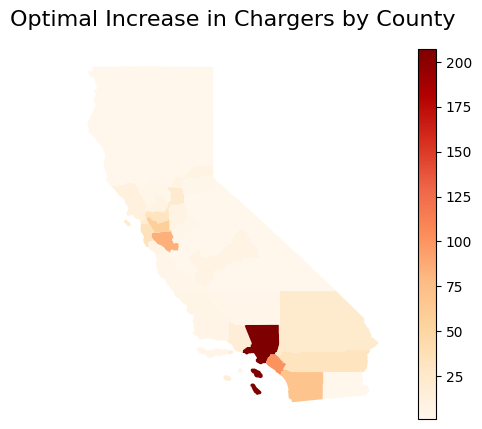

In [ ]:
# Step 2: Create a DataFrame for optimal increases in chargers

# Convert dictionary to DataFrame
optimal_increase_df = pd.DataFrame(list(optimal_chargers.items()), columns=['County', 'Optimal_Increase'])

# Step 3: Merge the GeoDataFrame with the optimization data
# Ensure both datasets have matching keys for the counties
county_geo = county_geo.merge(optimal_increase_df, how="left", left_on="NAME", right_on="County")

# Step 4: Plot the choropleth map
plt.figure(figsize=(12, 8))
county_geo.plot(
    column="Optimal_Increase",  # The data to visualize
    cmap="OrRd",               # Color map
    legend=True,               # Show legend
    missing_kwds={"color": "lightgrey", "label": "No Data"}  # Handle missing data
)
plt.title("Optimal Increase in Chargers by County", fontsize=16)
plt.axis("off")  # Turn off axes
plt.show()

#### total ev map

<Figure size 1200x800 with 0 Axes>

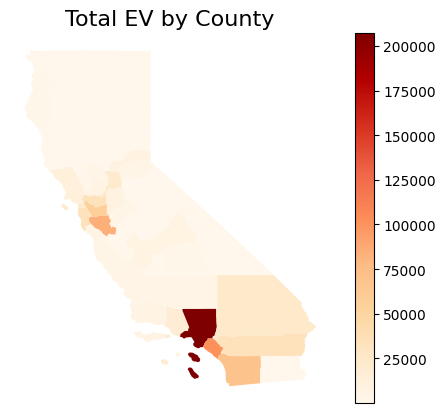

In [ ]:
# Create the DataFrame
total_ev_df = data[['County', 'Total_EV']]

# Step 3: Merge the GeoDataFrame with the total_ev data
# Ensure both datasets have matching keys for the counties
county_geo = county_geo.merge(total_ev_df, how="left", left_on="NAME", right_on="County")

# Step 4: Plot the choropleth map
plt.figure(figsize=(12, 8))
county_geo.plot(
    column="Total_EV",  # The data to visualize
    cmap="OrRd",               # Color map
    legend=True,               # Show legend
    missing_kwds={"color": "lightgrey", "label": "No Data"}  # Handle missing data
)
plt.title("Total EV by County", fontsize=16)
plt.axis("off")  # Turn off axes
plt.show()

<Figure size 1200x800 with 0 Axes>

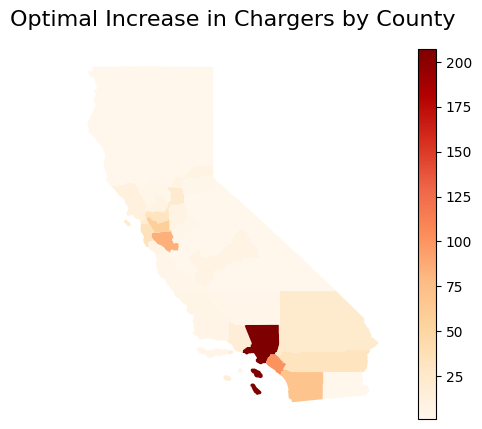

In [ ]:
# plot optimal increase in chargers
plt.figure(figsize=(12, 8))
county_geo.plot(
    column="Optimal_Increase",  # The data to visualize
    cmap="OrRd",               # Color map
    legend=True,               # Show legend
    missing_kwds={"color": "lightgrey", "label": "No Data"}  # Handle missing data
)
plt.title("Optimal Increase in Chargers by County", fontsize=16)
plt.axis("off")  # Turn off axes
plt.show()


In [ ]:
optimal_chargers

{'Alameda': 57,
 'Alpine': 5,
 'Amador': 9,
 'Butte': 12,
 'Calaveras': 8,
 'Colusa': 2,
 'Contra Costa': 33,
 'Del Norte': 2,
 'El Dorado': 12,
 'Fresno': 7,
 'Glenn': 5,
 'Humboldt': 12,
 'Imperial': 6,
 'Inyo': 1,
 'Kern': 4,
 'Kings': 2,
 'Lake': 106,
 'Lassen': 1,
 'Los Angeles': 207,
 'Madera': 3,
 'Marin': 22,
 'Mariposa': 1,
 'Mendocino': 5,
 'Merced': 6,
 'Modoc': 1,
 'Mono': 1,
 'Monterey': 7,
 'Napa': 11,
 'Nevada': 7,
 'Orange': 101,
 'Placer': 11,
 'Plumas': 34,
 'Riverside': 33,
 'Sacramento': 23,
 'San Benito': 45,
 'San Bernardino': 24,
 'San Diego': 69,
 'San Francisco': 21,
 'San Joaquin': 11,
 'San Luis Obispo': 9,
 'San Mateo': 34,
 'Santa Barbara': 12,
 'Santa Clara': 84,
 'Santa Cruz': 22,
 'Shasta': 4,
 'Sierra': 3,
 'Siskiyou': 1,
 'Solano': 10,
 'Sonoma': 18,
 'Stanislaus': 14,
 'Sutter': 9,
 'Tehama': 3,
 'Trinity': 2,
 'Tulare': 6,
 'Tuolumne': 9,
 'Ventura': 23,
 'Yolo': 13,
 'Yuba': 9}

#### second stage map

<Figure size 1200x800 with 0 Axes>

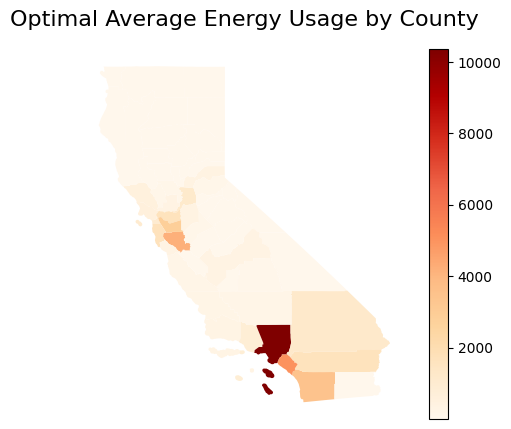

In [ ]:
# Step 2: Create a DataFrame for energy usage in chargers, calculate average energy usage of all scenarios

# Calculate the average energy usage for each county
average_energy_usage = {county: 0 for county in baseline_demand.keys()}
for (county, scenario), energy in optimal_energy_usage.items():
    average_energy_usage[county] += energy

# Divide by the number of scenarios to compute the average
for county in average_energy_usage.keys():
    average_energy_usage[county] /= len(scenarios)

# Convert to a DataFrame
average_energy_df = pd.DataFrame(list(average_energy_usage.items()), columns=["County", "AverageEnergyUsage"])


# Step 3: Merge the GeoDataFrame with the optimization data
# Ensure both datasets have matching keys for the counties
county_geo = county_geo.merge(average_energy_df, how="left", left_on="NAME", right_on="County")

# Step 4: Plot the choropleth map
plt.figure(figsize=(12, 8))
county_geo.plot(
    column="AverageEnergyUsage",  # The data to visualize
    cmap="OrRd",               # Color map
    legend=True,               # Show legend
    missing_kwds={"color": "lightgrey", "label": "No Data"}  # Handle missing data
)
plt.title("Optimal Average Energy Usage by County", fontsize=16)
plt.axis("off")  # Turn off axes
plt.show()

#### Unmet demand

In [ ]:
county_geo.drop(columns=['County_x', 'County_y'], inplace=True)

<Figure size 1200x800 with 0 Axes>

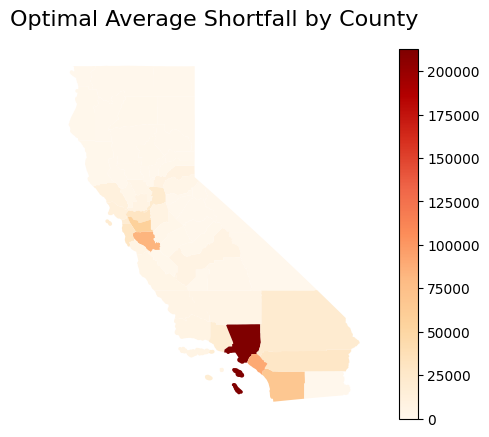

In [ ]:
# Step 2: Create a DataFrame for demand shortfall, calculate average shortfall of all scenarios

# Calculate the average shortfall for each county
average_shortfall = {county: 0 for county in baseline_demand.keys()}
for (county, scenario), shortfall in optimal_shortfall.items():
    average_shortfall[county] += shortfall

# Divide by the number of scenarios to compute the average
for county in average_shortfall.keys():
    average_shortfall[county] /= len(scenarios)

# Convert to a DataFrame
average_shortfall_df = pd.DataFrame(list(average_shortfall.items()), columns=["County", "AverageShortfall"])


# Step 3: Merge the GeoDataFrame with the optimization data
# Ensure both datasets have matching keys for the counties
county_geo = county_geo.merge(average_shortfall_df, how="left", left_on="NAME", right_on="County")

# Step 4: Plot the choropleth map
plt.figure(figsize=(12, 8))
county_geo.plot(
    column="AverageShortfall",  # The data to visualize
    cmap="OrRd",               # Color map
    legend=True,               # Show legend
    missing_kwds={"color": "lightgrey", "label": "No Data"}  # Handle missing data
)
plt.title("Optimal Average Shortfall by County", fontsize=16)
plt.axis("off")  # Turn off axes
plt.show()